## Load modules

In [ ]:
#!pip install bayesian-optimization
#!pip install miceforest --no-cache-dir

In [ ]:

import pandas as pd
import numpy as np 
import gc #free up memory
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf ##forest based imputation


import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score,precision_recall_curve,roc_curve, auc

from sklearn.preprocessing import RobustScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif


## `Dataset` class for ML preprocessing

The `Dataset` class is designed to handle the preprocessing and splitting of a dataset for machine learning tasks. Here is a summary of its functionality:

1. Initialization: The class takes in a pandas DataFrame (`df`) representing the dataset and the target variable (`target`). It also accepts additional parameters like `is_test` to indicate if the dataset is a test set, `scaler` for scaling numeric columns, and `trained_cols` for indicating specific columns to be used in the final dataset.

2. Preprocessing: The `preprocess()` method performs preprocessing tasks on the dataset. It includes basic imputations for missing values, smart imputations using the `miceforest` package for remaining missing values, scaling of numeric columns, and label encoding for binary columns. It also performs one-hot encoding for categorical columns.

3. Splitting Data: The `split_data()` method splits the preprocessed dataset into training, evaluation, and testing sets. It takes parameters like `test_size` and `eval_size` to control the size of the test and evaluation sets, respectively. It prints information about the sizes and positive rates of each split.


In [ ]:
class Dataset:
    def __init__(self, df, target,is_test=False, scaler=None, trained_cols = None):
        self.df = df
        self.is_test = is_test
        self.target = target
        self.X = self.df.drop(columns=[self.target])
        self.X_train = None
        self.X_test = None
        self.X_eval = None
        self.y_eval = None
        self.y_train = None
        self.y_test = None
        self.preprocessed = False
        self.scaler = scaler
        self.label_encoders = None
        self.final_X_cols = None
        if self.is_test:
          self.y = None
        else:
          self.y = self.df[self.target]

    ##method to pre-process the df
    def preprocess(self, impute_dict=None, imputation_kernel_iterations = 4, imputation_kernel_ntrees = 50):
       # Basic imputations
      if impute_dict is not None:
        print(f'Performing basic imputations based on {len(impute_dict)} features supplied impute_dict')
        for col, strategy in impute_dict.items():
          if col not in self.X.columns:
            print(f"Skipping imputation for column '{col}' as it does not exist in the dataset.")
            continue
          if strategy == 'mean':
              self.X[col].fillna(self.X[col].mean(), inplace=True)
          elif strategy == 'median':
              self.X[col].fillna(self.X[col].median(), inplace=True)
          elif isinstance(strategy, str) and strategy.startswith('percentile_'):
              percentile = float(strategy.split('_')[1])
              self.X[col].fillna(self.X[col].quantile(percentile / 100), inplace=True)
          elif isinstance(strategy, (int, float)):
              self.X[col].fillna(strategy, inplace=True)
          else:
              raise ValueError(f"Invalid imputation strategy for column '{col}'.")
    #find numeric columns
      numeric_cols = self.X.select_dtypes(include=['int64', 'float64']).columns

      ## smart impuations - decision tree based method
      count_NA = self.X.isna().sum()
      remaining_NA_cols = count_NA[count_NA>0].shape[0]
      if  remaining_NA_cols> 0:
        print(f'Performing decision-tree based imputations of {remaining_NA_cols} remaining features with missing data')
        kernal = mf.ImputationKernel(
            self.X[numeric_cols],
            random_state=42
            )
        # Run the MICE algorithm for 2 iterations
        kernal.mice(iterations=imputation_kernel_iterations,
                    n_estimators=imputation_kernel_ntrees)
        X_numeric_imputed = kernal.complete_data()
        self.X[numeric_cols] = X_numeric_imputed
      
      ##scale numeric cols
      print('Scaling numeric data')
      if self.scaler is None:
        self.scaler = StandardScaler()
        self.X[numeric_cols] = self.scaler.fit_transform(self.X[numeric_cols])
      else:
        self.X[numeric_cols] = self.scaler.transform(self.X[numeric_cols])
  
      
      # Perform label encoding for binary columns
      print('One-hot-encoding categorical vars')
      binary_cols = [col for col in self.X.columns if self.X[col].nunique() == 2]
      self.label_encoders = {}

      # Label encode binary columns
      for col in binary_cols:
          label_encoder = LabelEncoder()
          self.X[col] = label_encoder.fit_transform(self.X[col])
          # Store the label encoder for later use
          self.label_encoders[col] = label_encoder
      
      # Perform one-hot encoding for categorical columns
      categorical_cols = [col for col in self.X.columns if self.X[col].dtype == 'object' and col not in binary_cols]
      self.X = pd.get_dummies(self.X, columns=categorical_cols)

      if self.final_X_cols is not None:
        missing_cols = set(self.final_X_cols) - set(self.X.columns)
        for col in missing_cols:
          self.X[col] = 0
        self.X = self.X[self.final_X_cols]

      self.preprocessed = True
    

    def split_data(self, test_size=0.15,eval_size = 0.15, random_state=42):
        if not self.preprocessed:
          raise RuntimeError("Data has not been preprocessed. Please run the preprocess method.")
        
        if self.is_test:
          raise RuntimeError("Cannot run split_data() method on a test set")

        
        X_train_eval, self.X_test, y_train_eval, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )

        eval_split_size = eval_size/(1-test_size)
        self.X_train, self.X_eval, self.y_train, self.y_eval = train_test_split(
            X_train_eval, y_train_eval, test_size=eval_split_size, random_state=random_state)

        print(f"{self.X_train.shape[0]} training samples, {self.X_eval.shape[0]} evaluation samples and {self.X_test.shape[0]} testing samples")
        print(f"{self.y_train.sum()} ({self.y_train.mean()*100:.3f}%) positives in training set")
        print(f"{self.y_eval.sum()} ({self.y_eval.mean()*100:.3f}%) positives in evaluation set")
        print(f"{self.y_test.sum()} ({self.y_test.mean()*100:.3f})% positives in testing set")


## `Model` Class for training xgboost models

The model class provides a streamlined workflow for feature selection, model training, and evaluation of xgboost models.

Here is a summary of the key features and methods of the Model class:



1.   **Initialisation**: The class is initialized with the necessary input data using the `Dataset` class, including the training and test sets (`X_train`, `X_test`) and their corresponding target variables (`y_train`, `y_test`).
2.   **Feature Selection**: The `select_features()` method allows you to perform feature selection using the `sklearn.feature_selection.SelectKBest` algorithm. It selects the top num_features based on mutual information classification scores.
3. **Model Training**: The `train_model()` method trains an XGBoost classifier using the specified xgboost_params. It uses the training data and evaluates the model's performance on the evaluation set (`X_eval`, `y_eval`). Early stopping is implemented to prevent overfitting.
4. **Model Evaluation**: The `evaluate_model()` method calculates and prints various evaluation metrics, including F1 score, accuracy, precision, recall, specificity, ROC AUC score, and balanced accuracy. It also selects the optimal threshold for determining binary predictions based on the F1 score.
5. **Performance Visualisation**: The class provides several plotting methods to visualise model performance, including `plot_roc_auc()` to visualize the ROC curve and calculate the AUC score, `plot_predictions()` to plot the predicted probabilities against the true labels, and `plot_feature_importance()` to display the feature importances using a bar plot.

In [ ]:
class Model:
    def __init__(self, dataset_class):
        if not isinstance(dataset_class.X_train, pd.DataFrame) or not isinstance(dataset_class.X_test, pd.DataFrame):
            raise TypeError("X_train and X_test must be pandas DataFrames")
        if not isinstance(dataset_class.y_train, pd.Series) or not isinstance(dataset_class.y_test, pd.Series):
            raise TypeError("y_train and y_test must be pandas Series")
        self.X_train = dataset_class.X_train
        self.X_eval = dataset_class.X_eval
        self.X_test = dataset_class.X_test
        self.y_train = dataset_class.y_train
        self.y_eval = dataset_class.y_eval
        self.y_test = dataset_class.y_test
        self.y_pred = None
        self.xgboost_params = None
        self.num_features = None
        self.feature_names = dataset_class.X_train.columns
        self.selected_features = None
        self.model = None
    
    def select_features(self, num_features):
      if not isinstance(num_features, int) :
        raise TypeError("num_features must be an int")
      #ensure num features is in correct range
      num_features = max(min(int(num_features), self.X_train.shape[1]), 2)
      ##perform feature selection
      selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
      selector.fit(self.X_train, self.y_train)
      mask = selector.get_support()
      ##splice X datasets for the selected features
      self.selected_features = self.feature_names[mask]
      self.X_train = self.X_train[self.selected_features]
      self.X_eval = self.X_eval[self.selected_features]
      self.X_test = self.X_test[self.selected_features]
    
    def train_model(self, xgboost_params):
      self.xgboost_params = xgboost_params
      dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
      deval = xgb.DMatrix(self.X_eval, label = self.y_eval)
      self.model = xgb.train(self.xgboost_params,
                             dtrain = dtrain, 
                             evals=[(deval, 'eval')],verbose_eval=False,
                             num_boost_round=700,early_stopping_rounds=20 )
      print('Model training completed')
    
    def evaluate_model(self):
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test, label=self.y_test)
        self.y_pred = self.model.predict(dtest)
      ##select best threshold for determining 
      best_threshold = 0
      best_f1 = 0
      
      # Iterate over different threshold values
      for threshold in np.arange(0.1, 1.0, 0.05):
          y_pred_binary = (self.y_pred >= threshold).astype(int)
          f1 = f1_score(self.y_test, y_pred_binary)

          if f1 > best_f1:
              best_f1 = f1
              best_threshold = threshold
      
      # Convert predicted probabilities to binary predictions based on the best threshold
      y_pred_binary = (self.y_pred >= best_threshold).astype(int)
      
      # Calculate accuracy metrics
      accuracy = accuracy_score(self.y_test, y_pred_binary)
      precision = precision_score(self.y_test, y_pred_binary)
      recall = recall_score(self.y_test, y_pred_binary)
      specificity = recall_score(self.y_test, y_pred_binary, pos_label=0)
      roc_auc = roc_auc_score(self.y_test, self.y_pred)
      balanced_accuracy = balanced_accuracy_score(self.y_test, y_pred_binary)
      
      # Print the metrics
      print("Optimal Threshold:", best_threshold)
      print("F1 Score:", best_f1)
      print("Accuracy:", accuracy)
      print("Precision:", precision)
      print("Recall (Sensitivity):", recall)
      print("Specificity (True Negative Rate):", specificity)
      print("ROC AUC Score:", roc_auc)
      print("Balanced Accuracy:", balanced_accuracy)

    
    def plot_roc_auc(self):
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test, label=self.y_test)
        self.y_pred = self.model.predict(dtest)
      
      fpr, tpr, _ = roc_curve(self.y_test, self.y_pred)
      roc_auc = roc_auc_score(self.y_test, self.y_pred)
      plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()
    def plot_predictions(self):
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test, label=self.y_test)
        self.y_pred = self.model.predict(dtest)
            
      sns.regplot(x=self.y_pred, y=self.y_test, scatter_kws={'alpha': 0.3})
      plt.xlabel('Predicted Probabilities')
      plt.ylabel('True Labels')
      plt.title('Predicted Probabilities vs. True Labels')
      plt.show()
    
    def plot_feature_importance(self, n_features =None):
      

      feature_importances = self.model.get_score(importance_type='weight')
      if n_features is None:
        n_features = len(feature_importances)

      sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

      # Extract feature names and importance scores
      features = [x[0] for x in sorted_feature_importances]
      importances = [x[1] for x in sorted_feature_importances]

      # Create a bar plot of sorted feature importances
      plt.figure(figsize=(8, 9.5))
      plt.barh(features[0:(n_features-1)][::-1], 
               importances[0:(n_features-1)][::-1])
      plt.xlabel('Importance')
      plt.ylabel('Features')
      plt.title(f'Top {n_features} Features')
      plt.tight_layout()
      plt.show()


In [ ]:
df= pd.read_csv('all_data_merged.csv')


In [ ]:
lr_results = pd.read_csv('logistic_regression_results.csv')
important_features = lr_results.feature[lr_results.deviance_reduction >0.25]
less_relavent_features = lr_results.feature[lr_results.deviance_reduction <= 0.25]

In [ ]:
impute_dict = {feature: 'median' for feature in less_relavent_features}
impute_dict['own_car_age'] = 'percentile_95'

In [ ]:
data = Dataset(df, target = 'target')
data.preprocess(impute_dict=impute_dict,
                imputation_kernel_iterations=3, imputation_kernel_ntrees=50)

Performing basic imputations based on 114 features supplied impute_dict
Performing decision-tree based imputations of 10 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars


In [ ]:
data.split_data()
data.X_train.head(20)

215257 training samples, 46127 evaluation samples and 46127 testing samples
17250 (8.014%) positives in training set
3858 (8.364%) positives in evaluation set
3717 (8.058)% positives in testing set


,sk_id_curr,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,...,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_other,emergencystate_mode_No,emergencystate_mode_Yes,emergencystate_mode_other,age_group_30-45,age_group_45-60,age_group_60+,age_group_under 30
46832,-1.205696,0,1,1,-0.577538,-0.180488,-0.180216,-0.334426,-0.226468,0.310593,...,1,0,0,1,0,0,0,0,1,0
201944,0.543919,0,0,0,0.807273,-0.360775,0.199940,-0.499605,0.382619,-0.149452,...,0,0,1,0,0,1,0,0,0,1
131335,-0.251576,0,1,0,-0.577538,0.237017,-1.159238,-0.957570,-1.140099,0.756322,...,0,0,0,1,0,0,1,0,0,0
192603,0.439454,1,1,1,-0.577538,-0.256398,-0.817476,-0.938941,-0.725919,1.078997,...,1,0,0,1,0,0,1,0,0,0
244844,1.023441,0,1,1,2.192084,0.616567,1.013426,1.480981,0.979524,0.139676,...,0,0,1,0,0,1,1,0,0,0
237241,0.939843,0,0,0,0.807273,0.085197,-1.041084,-0.880260,-0.969554,-0.765810,...,0,0,1,0,0,1,0,0,0,1
30269,-1.391658,0,0,1,-0.577538,-0.237421,-1.152888,-1.114676,-1.091372,-0.192254,...,0,0,1,0,0,1,0,0,0,1
297908,1.624238,0,1,0,-0.577538,0.047242,-1.064339,-1.118091,-1.091372,-0.665963,...,0,0,0,1,0,0,1,0,0,0
81607,-0.812788,0,1,0,2.192084,4.412069,5.208759,3.035582,4.634045,3.733564,...,1,0,0,1,0,0,0,1,0,0
56546,-1.096026,0,0,1,0.807273,-0.370264,-0.534120,-0.626283,-0.725919,-0.885177,...,1,0,0,1,0,0,0,0,0,1


## Train a model containing all features

In [ ]:
model = Model(dataset_class=data)


In [ ]:
xgb_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': 15,
    'subsample':0.6,
    'colsample_bytree':0.5
}
model.train_model(xgb_params)


Model training completed


In [ ]:
model.evaluate_model()

Optimal Threshold: 0.6500000000000001
F1 Score: 0.31884057971014496
Accuracy: 0.8573503587920307
Precision: 0.2591283863368669
Recall (Sensitivity): 0.4143126177024482
Specificity (True Negative Rate): 0.8961801461919359
ROC AUC Score: 0.7700383575099323
Balanced Accuracy: 0.6552463819471921


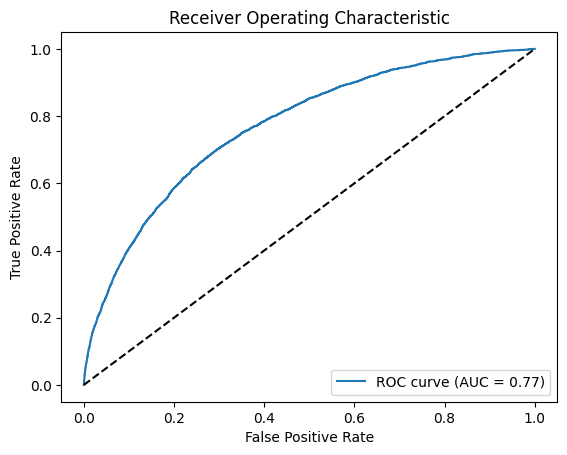

In [ ]:
model.plot_roc_auc()

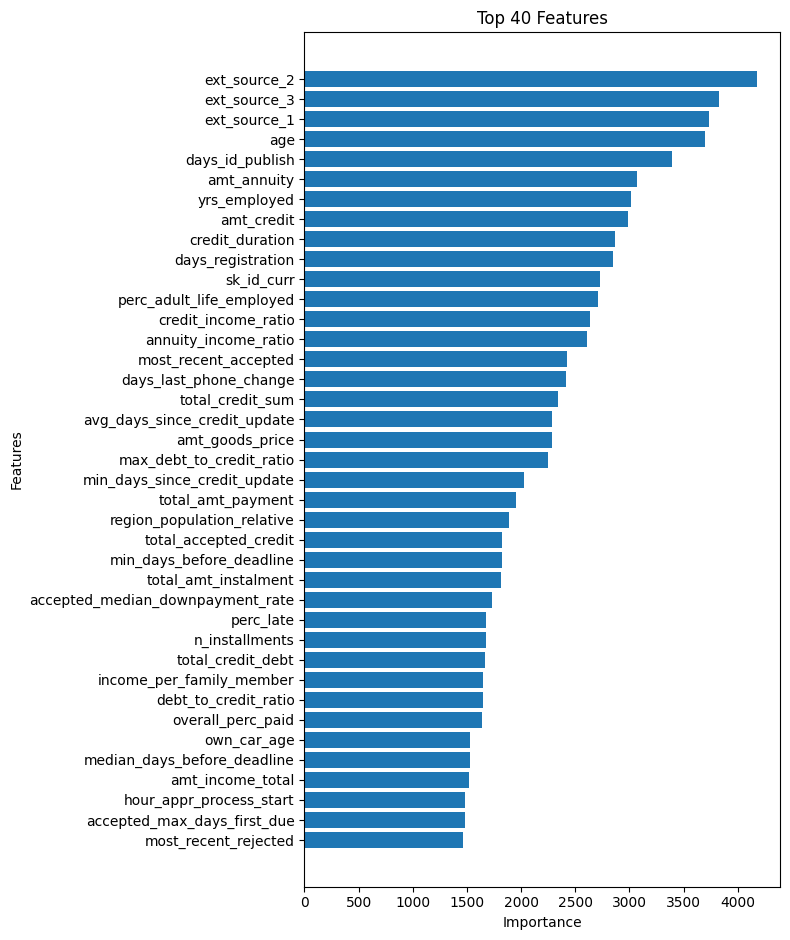

In [ ]:
model.plot_feature_importance(n_features= 40)

In [ ]:
model_top75 = Model(dataset_class=data)
model_top75.select_features(num_features=75)
print(f"data has {data.X_train.shape[1]} features, model contains {model_top75.X_train.shape[1]} features")

data has 302 features, moodel contains 75 features


In [ ]:
model_top75.selected_features

Index(['flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_credit',
       'amt_annuity', 'own_car_age', 'flag_mobil', 'flag_emp_phone',
       'flag_cont_mobile', 'flag_phone', 'ext_source_2', 'ext_source_3',
       'elevators_avg', 'elevators_mode', 'elevators_medi',
       'obs_30_cnt_social_circle', 'def_30_cnt_social_circle',
       'obs_60_cnt_social_circle', 'def_60_cnt_social_circle',
       'flag_document_3', 'amt_req_credit_bureau_mon',
       'amt_req_credit_bureau_qrt', 'is_childless', 'count_loan_types',
       'debt_to_credit_ratio', 'n_months_balances', 'avg_balance',
       'mean_weighted_balanced', 'max_balance', 'max_weighted_balance',
       'sd_balance', 'max_credit_limit', 'total_drawings_sum',
       'max_mth_drawings', 'total_weighted_point_of_sale_drawings',
       'toatl_inst_min_regularity', 'total_payments_sum', 'total_payments_max',
       'total_receivable_sum', 'total_weighted_receivable_sum',
       'avg_receivable_sum', 'avg_weighted_receivable_sum',

In [ ]:
##train the feature selected model with same param dictionary 
model_top75.train_model(xgb_params)

Model training completed


In [ ]:
# Define the objective function for Bayesian optimization
def xgb_objective(n_estimators, gamma, scale_pos_weight,colsample_bynode,
                  learning_rate, max_depth, subsample, colsample_bytree):
    # Convert hyperparameters to appropriate types
    learning_rate = float(learning_rate)
    max_depth = int(max_depth)
    subsample = max(min(float(subsample), 1), 0)
    colsample_bytree = max(min(float(colsample_bytree), 1), 0)
    colsample_bynode = max(min(float(colsample_bytree), 1), 0)



    # Create the XGBClassifier model with the specified hyperparameters
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        gamma = gamma,
        scale_pos_weight=scale_pos_weight,
        colsample_bynode=colsample_bynode,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    # Perform cross-validation and calculate the ROC AUC score
    roc_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()

    # Return the negative ROC AUC score (Bayesian optimization minimizes the objective function)
    return -roc_auc

# Define the parameter ranges for Bayesian optimization
pbounds = {
    'n_estimators':(100, 1250),
    'gamma':(0.2, 1),
    'scale_pos_weight':(1,50),
    'colsample_bynode' : (0.3,1),
    'learning_rate': (0.001, 0.1),
    'max_depth': (3, 14),
    'subsample': (0.25, 1),
    'colsample_bytree': (0.25, 1)
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=xgb_objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=10, n_iter=30)

# Get the best hyperparameters and maximum ROC AUC score
best_params = optimizer.max['params']
best_score = -optimizer.max['target']




|   iter    |  target   | colsam... | colsam... |   gamma   | learni... | max_depth | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------


ValueError: ignored

In [ ]:
# Train the final XGBClassifier model with the best hyperparameters
best_model = xgb.XGBClassifier(
    
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)
best_model.fit(X, y)